In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal

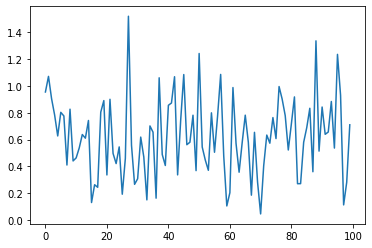

In [2]:
plt.plot(np.random.rayleigh(0.5,100))

<Figure size 432x288 with 0 Axes>

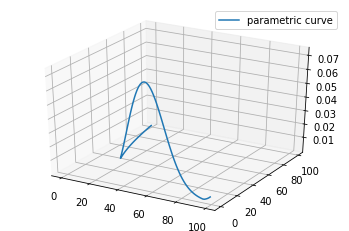

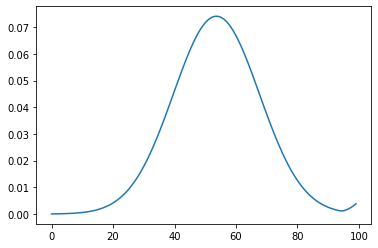

0.0 2.8746215706302247


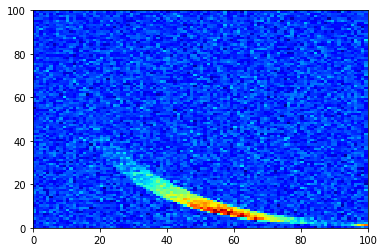

In [3]:
def shifted_gaussian(size, std, shift):
    gaussian = signal.gaussian(size,std)
#     gaussian = signal.general_gaussian(size,p=1.25,sig=std)
#     gaussian = signal.flattop(size)
#     gaussian = signal.windows.general_hamming(size,0.75)
    gaussian = np.roll(gaussian, shift, axis=None)
    tau2 = -(size-1) / np.log(0.01)
    window2 = signal.exponential(size, size-shift, tau2, False)
    return window2*gaussian

def scaled_2d_gaussian(size):
    mean = [0,0]
    cov = [[1, 0], [0, 1]]  # diagonal covariance
    w = np.random.multivariate_normal(mean, cov, (size,size)).T
    w = (w[1]-w[1].min())/(w[1].max()-w[1].min())
    return w

def whistler(A,B, size=257):
    L_min, L_max = 1.4, 8
    L = np.linspace(L_min, L_max, size)
    return L, np.array(10**(A)*(10**L)**(B))

def whistlers(A,B,b,size=257):
    A = 0
    B = np.linspace(B,B+b,100)
    W = scaled_2d_gaussian(size)
#     W = np.full((size,size),0)
    
    std = int(size/7)
    shift = -int(size/19)
    
    fig = plt.figure()
    axis, ampl = whistler(A,-0.4, size=size)
    x,y,z = np.array(list(range(size))), (ampl/ampl.max())*(size-1),shifted_gaussian(size, std, shift)
    ax = fig.gca(projection='3d')
    ax.plot(x, y, z, label='parametric curve')
    ax.legend()
    plt.figure()
    plt.plot(shifted_gaussian(size, std, shift))
    plt.show()

    y_max = 0
    for i in B:
        axis, ampl = whistler(A,i, size=size)
        y_max = max(y_max, ampl.max())
        
    for i in B:
        axis, ampl = whistler(A,i, size=size)
        x,y,z = np.array(list(range(size))), (ampl/y_max)*(size-1),shifted_gaussian(size, std, shift)+shifted_gaussian(size, std, shift*3)
        ix = 0
        for i,j in zip(x,y):
            W[i,math.floor(j)] += z[ix]
            ix += 1
    return W
    

plt.figure()
Z = whistlers(0,-0.3,0.05,100)
print(Z.min(), Z.max())
plt.pcolormesh(Z.T, cmap='jet')
plt.show()

In [ ]:
# plt.figure()
# B = [-0.5, -0.51, -0.52, -0.53, -0.54, -0.55, -0.56]
# B = np.linspace(-0.2,-0.2+0.09,50)
# size = 50
# for i in B:
#     axis, ampl = whistler(0,i, size=size)
#     x, y, z= np.array(list(range(size))), (ampl/ampl.max())*(size-1),np.full(size,1)
#     plt.scatter(x, y,z)

# size = 50
# plt.figure()
# plt.plot(shifted_gaussian(size, int(size/10), -int(size/5)))

# fig = plt.figure()
# axis, ampl = whistler(0,-0.4, size=size)
# x,y,z = np.array(list(range(size))), (ampl/ampl.max())*(height-1),shifted_gaussian(size, int(size/10), -int(size/5))
# ax = fig.gca(projection='3d')
# ax.plot(x, y, z, label='parametric curve')
# ax.legend()
# # plt.show()


### Whistler spectrorgam

[0 1 2 3 4] [99.         91.68575408 84.91189396 78.63849524 72.82858319]


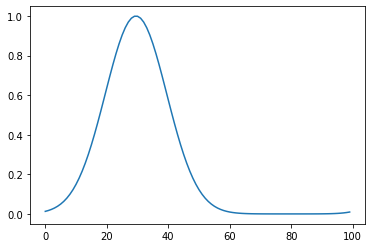

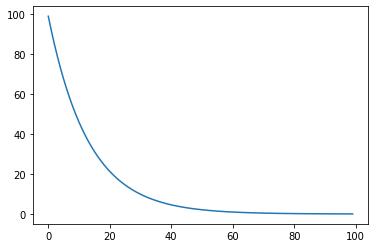

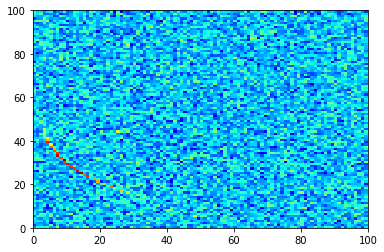

In [100]:
width = 100
height = width

gaussian = signal.gaussian(width,int(width/10))
shifted_gaussian = np.roll(gaussian, -int(2*width/10), axis=None)

axis, ampl = whistler_simulation(0,-0.5, data_point=width)
x,y,z = np.array(list(range(width))), (ampl/ampl.max())*(height-1),shifted_gaussian# np.full(width,1)#shifted_gaussian

plt.figure()
plt.plot(x,shifted_gaussian)

plt.figure()
plt.plot(x,y)

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot(x, y, z, label='parametric curve')
# ax.legend()
# plt.show()

print(x[:5], y[:5])

mean = [0,0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
w = np.random.multivariate_normal(mean, cov, (width,height)).T
w = (w[1]-w[1].min())/(w[1].max()-w[1].min())
ix = 0
for i,j in zip(x,y):
    w[i,math.floor(j)] += z[ix]
    ix += 1
plt.figure()
plt.pcolormesh(w,cmap='jet')
plt.show()

(257, 257) 1.0 0.0


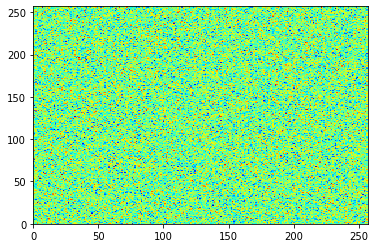

In [76]:
from sklearn.preprocessing import MinMaxScaler
mean = [0,0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
z = np.random.multivariate_normal(mean, cov, (width,height)).T
z = (z[1]-z[1].min())/(z[1].max()-z[1].min())
# z = MinMaxScaler().fit_transform(z[1])
print(z.shape, z.max(), z.min())
plt.pcolormesh(z,cmap='jet')
# plt.axis('equal')
plt.show()